In [1]:
# aim : predict earnings for foreign movies in the US
from bs4 import BeautifulSoup
import requests
import pandas as pd
import time
import scraping
import constants
import os
import numpy as np
import re
import seaborn as sns
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from seaborn import plt

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection  import KFold
from sklearn import preprocessing

import scipy.stats as stats
import patsy
import statsmodels.api as sm
%matplotlib inline

In [2]:
df = pd.read_csv('data/data_salary.csv', index_col=0)

# Adjust for inflation


In [3]:
with open ('data/inflation_multiplier.pkl', 'rb') as fp:
    inflation_mult = pickle.load(fp)

In [4]:
df['inflation'] = df['draft_year'].map(inflation_mult)

In [5]:
df['adjusted_salary'] = df['inflation'] * df['salary']

In [7]:
def basic_plot(x_col, y_col, df, ax, x_label=None, y_label=None):
    if not x_label:
        x_label = x_col 
    if not y_label:
        y_label = y_col
    ax.scatter(df[x_col], df[y_col], label=y_label)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title('{} vs. {}'.format(x_label, y_label))
    

In [8]:
df = df.dropna()

In [9]:
df.columns

Index(['ast', 'ast_per_g', 'blk', 'college', 'draft_rank', 'draft_year',
       'end_age', 'fg', 'fg3', 'fg3_pct', 'fg3a', 'fg_pct', 'fga', 'ft',
       'ft_pct', 'fta', 'g', 'height_in', 'mp', 'mp_per_g', 'name',
       'name_index', 'no_of_seasons', 'per', 'pts', 'pts_per_g', 'reach_in',
       'start_age', 'stl', 'trb_per_g', 'weight_lb', 'wingspan_in', 'salary',
       'position', 'birthday', 'shoot', 'inflation', 'adjusted_salary',
       'month'],
      dtype='object')

In [10]:
df['log_salary'] = np.log(df.adjusted_salary)

# Regularization

In [157]:
# The numerical columns
x_columns = ['ast_per_g', 'blk', 'draft_rank', 'draft_year',
       'end_age', 'fg3_pct', 'fg_pct',
       'ft_pct', 'g', 'height_in', 'mp', 'mp_per_g',
       'no_of_seasons', 'pts', 'pts_per_g',
       'stl', 'trb_per_g',]
# need to add shoot and position
def preprocess(df, cols = None, intercept=False, y_val='adjusted_salary'):
    if not cols:
        cols = x_columns
    y_data = df[y_val]
    X_data = df[cols]
    X_sc=preprocessing.normalize(X_data, axis=0, norm='max')
    # turn back in DF
    X_sc=pd.DataFrame(X_sc)
    X_sc.columns = cols
    X_data.columns = cols
    return X_sc, y_data, X_data

In [60]:
folds = 4
alpha_list=[1e-7, 1e-5,1e-3,1e-2, 1e-1,1, 10, 1e4]
def pick_alpha(fold, X, y, alphas=None):
    if not alphas:
        alphas = alpha_list
    kf = KFold(n_splits=fold)

    all_scores=[]


    for train, test in kf.split(X):
        x_train=X.iloc[train]
        y_train=y.iloc[train]
        x_test=X.iloc[test]
        y_test=y.iloc[test]
        mse_score=[]
        for a in alphas:
            est=Lasso(alpha=a)
            est.fit(x_train,y_train)
            mse=np.mean((y_test-est.predict(x_test))**2)
            mse_score.append(mse)
        all_scores.append(mse_score)
    plt.figure(figsize=(8,6))
    plt.legend()
    for i in range(fold):
        plt.plot(np.log10(alphas), all_scores[i],label = 'cv %s'%i)
    # Calculate the mean and plot it
    mean = np.array(all_scores).mean(axis=0).tolist()
    plt.plot(np.log10(alphas), mean, label = 'mean')
    plt.legend()
    plt.xlabel('alphas')
    plt.ylabel('MSE')
    plt.ylim(0)
    plt.show()

In [62]:
# Take a quick look at our strongest features
def find_features(alpha, X, y, columns):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    est=Lasso(alpha=alpha)
    est.fit(X_train,y_train)
    zipped=zip(columns,est.coef_)
    features=sorted(zipped,key = lambda t: t[1],reverse=True)
    print(est.score(X_test, y_test))
    return [x for x in features if x[1] != 0] ,est
def print_summary (features, X, y):
    features = [x[0] for x in features]
    X_features = X[features]
    lsm = sm.OLS(y,X_features)
    fit = lsm.fit()
    fit.summary()


In [65]:
def print_coef(f, coef):
    zipped=zip(f,coef)
    features=sorted(zipped,key = lambda t: t[1],reverse=True)
    for (a,b) in features:
        print ('{}\t\t\t{}'.format(a,b))


# Players with draft rank <=30


/Users/josephinetirtanata/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


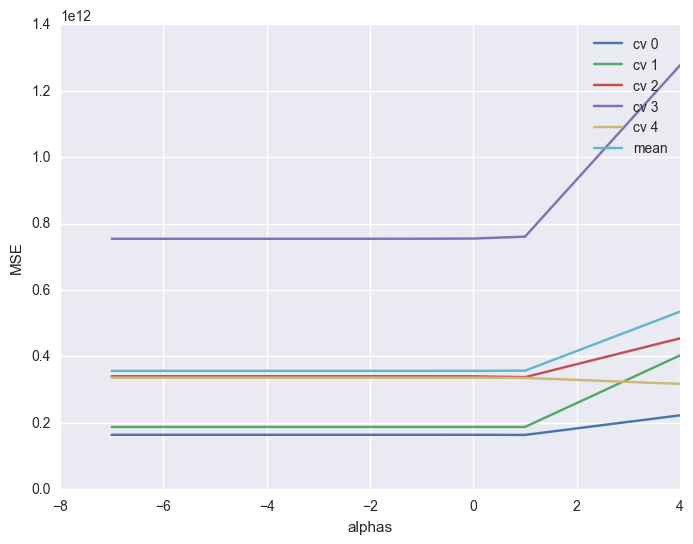

In [96]:
df_good = df[df.draft_rank <= 21]
X_sc, y_data, X_data = preprocess(df_good)
pick_alpha(5, X_sc, y_data)

In [97]:
features,est = find_features(1, X_sc, y_data, X_sc.columns)

0.801829154571


In [98]:
features

[('draft_year', 114760746.78379533),
 ('reach_in', 4623450.4725114498),
 ('pts_per_g', 1527692.7081031713),
 ('weight_lb', 696334.64212802961),
 ('ft_pct', 399803.73445661803),
 ('ast_per_g', 397350.10396927292),
 ('g', 389158.9517393508),
 ('no_of_seasons', 295976.33230258769),
 ('trb_per_g', 273918.66528445797),
 ('blk', 266287.84665598482),
 ('stl', 202443.12515316543),
 ('fg_pct', 141154.62005643192),
 ('mp', 123018.34379642816),
 ('fg3_pct', 68505.533569782085),
 ('end_age', -298718.98742772866),
 ('mp_per_g', -840729.13940078334),
 ('pts', -1292345.3182642951),
 ('draft_rank', -3153969.3678001207),
 ('height_in', -5375188.9076479729)]

# RCV

In [104]:
rcv = LinearRegression()
f = [x[0] for x in features]
X_sc, y_data, X_data = preprocess(df, cols=f)
xtrain, xtest, ytrain, ytest = train_test_split(X_data, y_data, test_size=0.3)

rcv.fit(X_data, y_data)
rcv.score(xtest, ytest)


0.73344147919834546

In [105]:
rcv.intercept_

-55743364.420349628

In [106]:
print_coef(f, rcv.coef_)

fg_pct			1012192.6726373836
fg3_pct			498625.88927214366
ft_pct			357797.9594545639
ast_per_g			113806.15717954311
pts_per_g			65706.72982934513
trb_per_g			36286.946707415154
draft_year			28838.58080240761
reach_in			21077.70288572733
g			6394.925162607486
weight_lb			1312.4388938450975
blk			774.2047702139826
stl			147.2438121840023
mp			-8.773262648261152
pts			-456.7123475311673
height_in			-15531.943106234394
mp_per_g			-25331.528032635135
draft_rank			-48152.98381312222
no_of_seasons			-63673.1587713377
end_age			-99369.48254329085



## Scaled

In [69]:
rcv = RidgeCV(cv=10)
f = [x[0] for x in features]
xtrain, xtest, ytrain, ytest = train_test_split(X_sc, y_data, test_size=0.3)

rcv.fit(X_sc, y_data)
rcv.score(xtest, ytest)


0.64077517857404243

In [70]:
rcv.intercept_

-2490072.2725587105

In [108]:
print_coef(f, rcv.coef_)

fg_pct			1012192.6726373836
fg3_pct			498625.88927214366
ft_pct			357797.9594545639
ast_per_g			113806.15717954311
pts_per_g			65706.72982934513
trb_per_g			36286.946707415154
draft_year			28838.58080240761
reach_in			21077.70288572733
g			6394.925162607486
weight_lb			1312.4388938450975
blk			774.2047702139826
stl			147.2438121840023
mp			-8.773262648261152
pts			-456.7123475311673
height_in			-15531.943106234394
mp_per_g			-25331.528032635135
draft_rank			-48152.98381312222
no_of_seasons			-63673.1587713377
end_age			-99369.48254329085


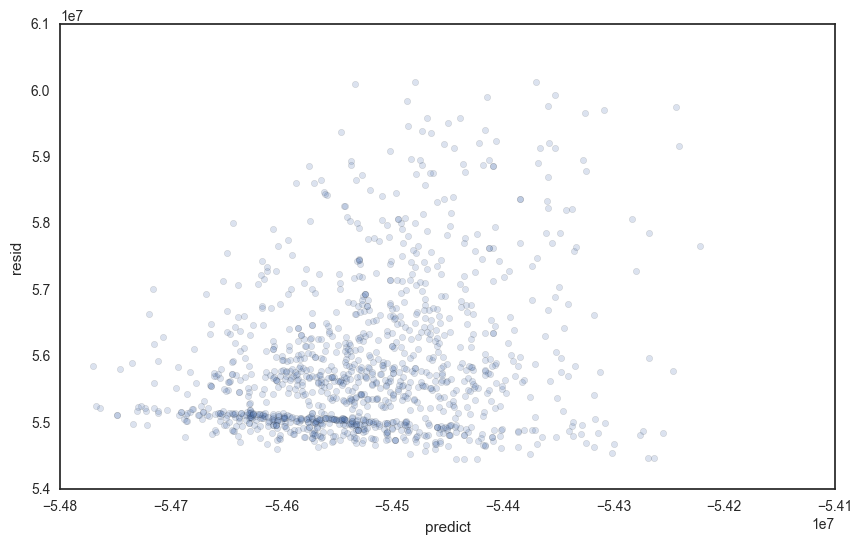

In [109]:
df['predict']=rcv.predict(X_sc)
df['resid']=df.adjusted_salary-df.predict
with sns.axes_style('white'):
    plot=df.plot(kind='scatter',
                  x='predict',y='resid',alpha=0.2,figsize=(10,6))

# Players with draft rank > 30

/Users/josephinetirtanata/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


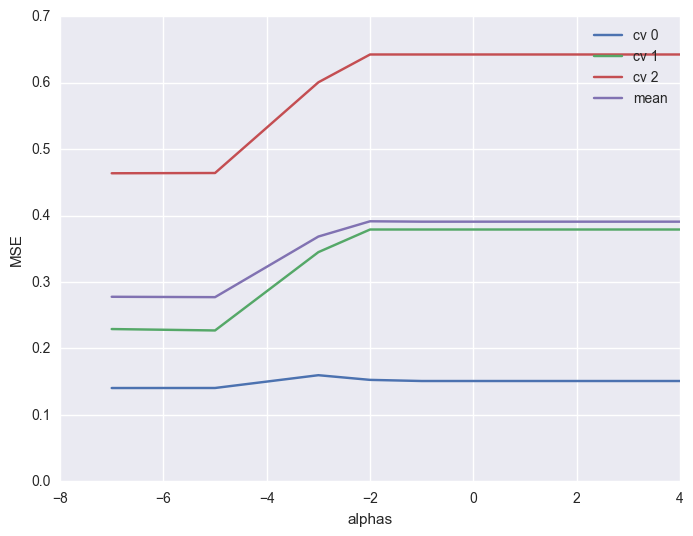

In [158]:
df_bad = df[df.draft_rank > 30]
X_sc, y_data, X_data = preprocess(df_bad, y_val ='log_salary')
pick_alpha(3, X_sc, y_data)


In [161]:
features,est = find_features(1e-5, X_sc, y_data, X_sc.columns)

0.164398678189


In [162]:
features

[('draft_year', 53.504602189748255),
 ('height_in', 1.5066790791530205),
 ('pts', 0.94106819034657208),
 ('trb_per_g', 0.24679418766806935),
 ('ast_per_g', 0.21909170313549503),
 ('no_of_seasons', 0.21072852626203797),
 ('fg3_pct', 0.18185995248884426),
 ('ft_pct', 0.096070551753321923),
 ('mp_per_g', 0.092670888913162344),
 ('blk', -0.029927632625447367),
 ('stl', -0.030268155746584501),
 ('mp', -0.20890233384181334),
 ('g', -0.39971421889610842),
 ('fg_pct', -0.61979171788331955),
 ('pts_per_g', -1.138091532174021),
 ('draft_rank', -1.3136554463446319),
 ('end_age', -1.4448494105593832)]

In [163]:
rcv = LinearRegression()
f = [x[0] for x in features]
X_sc, y_data, X_data = preprocess(df_bad, cols=f)
xtrain, xtest, ytrain, ytest = train_test_split(X_sc, y_data, test_size=0.3)

rcv.fit(X_sc, y_data)
rcv.score(xtest, ytest)

0.065158090636492028

In [164]:
rcv.intercept_



-22738901.644459825

In [165]:
mse = ((rcv.predict(xtest) - ytest)**2).mean()
mse

69583106256.27832

In [166]:
mse**0.5

263786.0994371734

In [167]:
print_coef(f, rcv.coef_)

draft_year			23371698.043235205
height_in			683211.8133261937
no_of_seasons			251692.15073484258
pts			112075.63962171467
mp			63496.17697418714
mp_per_g			60920.17006853729
ast_per_g			10852.68751952902
fg3_pct			-8918.338412949699
fg_pct			-15146.799413227214
pts_per_g			-42775.82174517395
blk			-44700.64538456965
trb_per_g			-65643.48582739137
stl			-154491.22898994706
g			-177072.1825824909
ft_pct			-230099.62193489273
draft_rank			-393083.5496537157
end_age			-418026.15627243894


/Users/josephinetirtanata/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/josephinetirtanata/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


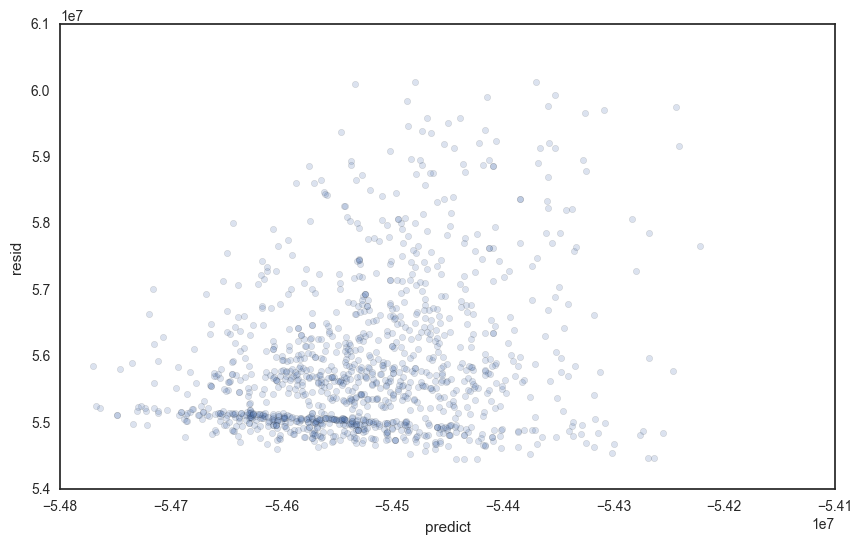

In [152]:
df_bad['predict']=rcv.predict(X_sc)
df_bad['resid']=df_bad.adjusted_salary-df_bad.predict
with sns.axes_style('white'):
    plot=df.plot(kind='scatter',
                  x='predict',y='resid',alpha=0.2,figsize=(10,6))

In [153]:
df['resid'].std()

1120530.685999122

In [154]:
def diagnostic_plot(x, y,label):
    s = len(x)
    plt.figure(figsize=(20,5))
    
    rgr = RidgeCV(cv=10)
    rgr.fit(x.reshape(s,1),y)
    pred = rgr.predict(x.reshape(s,1))

    plt.subplot(1, 3, 1)
    plt.scatter(x,y)
    plt.plot(x, pred, color='blue',linewidth=1)
    plt.title("Regression fit")
    plt.xlabel("x")
    plt.ylabel(label)
    
    plt.subplot(1, 3, 2)
    res = y - pred
    plt.scatter(pred, res)
    plt.title("Residual plot")
    plt.xlabel("prediction")
    plt.ylabel("residuals")
    
    plt.subplot(1, 3, 3)
    #Generates a probability plot of sample data against the quantiles of a 
    # specified theoretical distribution 
    stats.probplot(res, dist="norm", plot=plt)
    plt.title("Normal Q-Q plot")

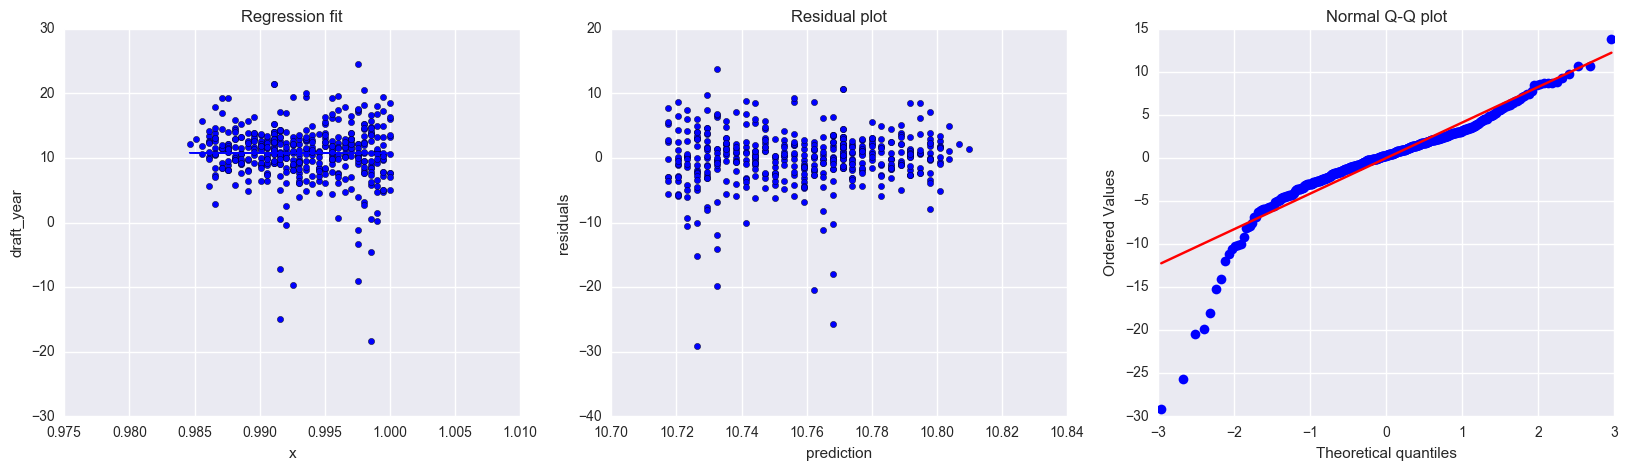

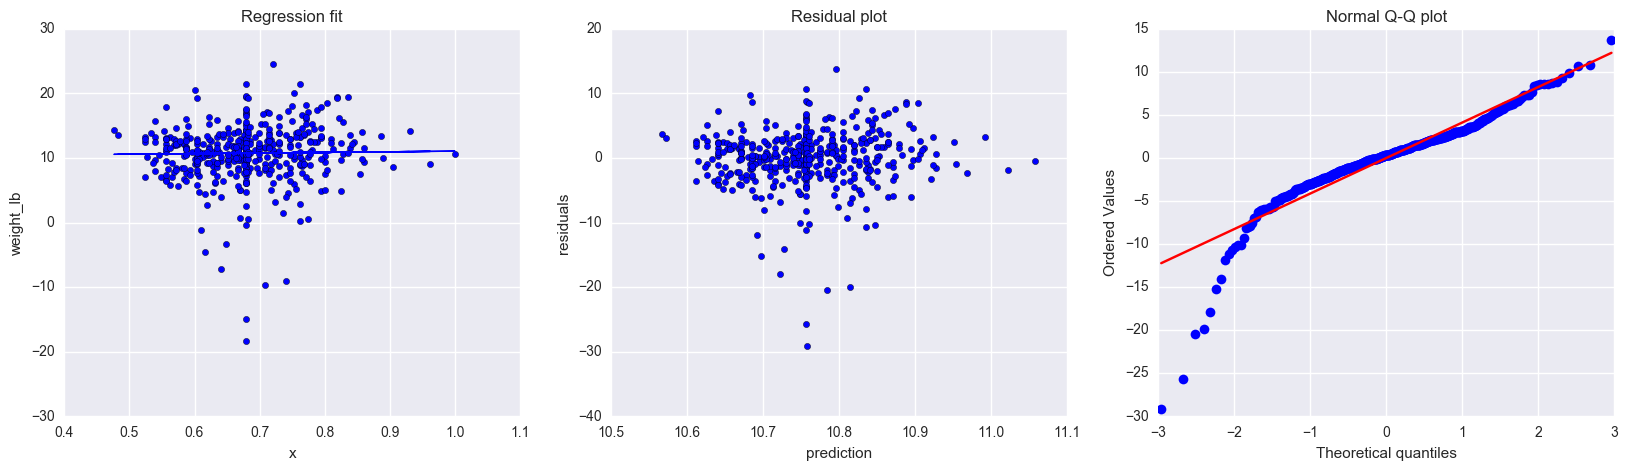

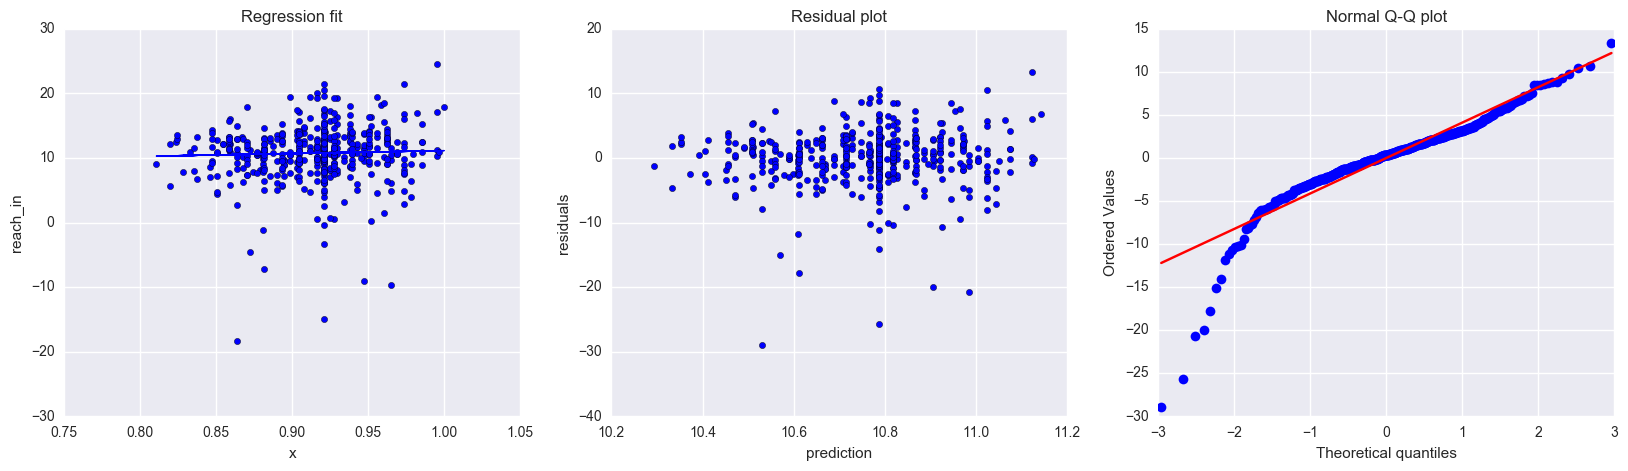

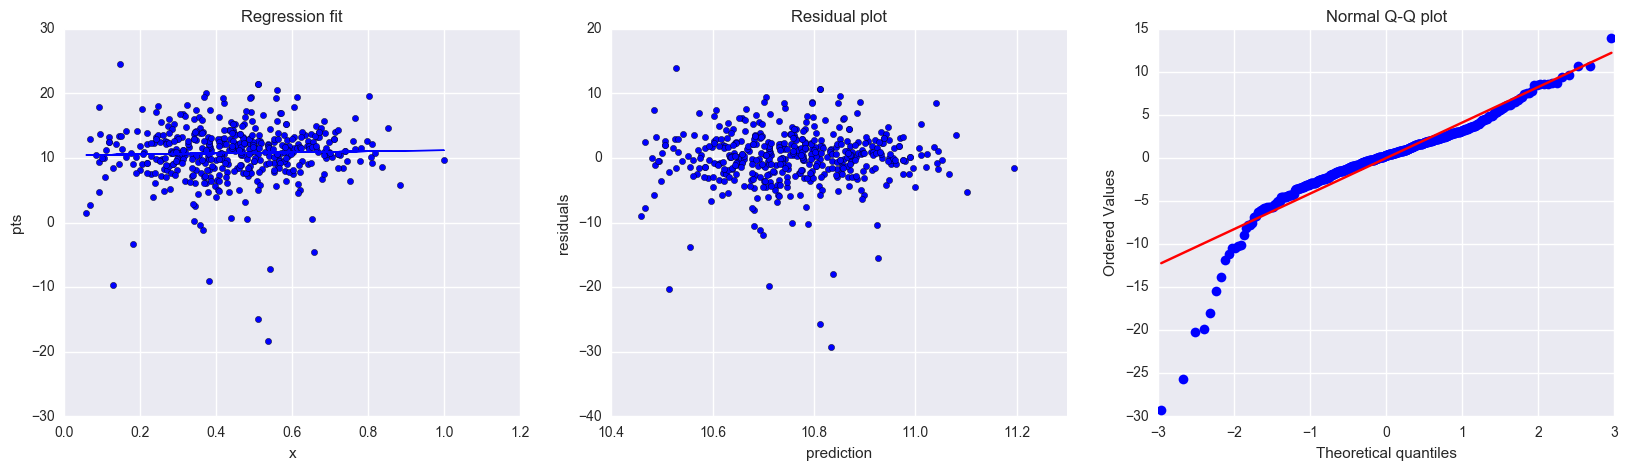

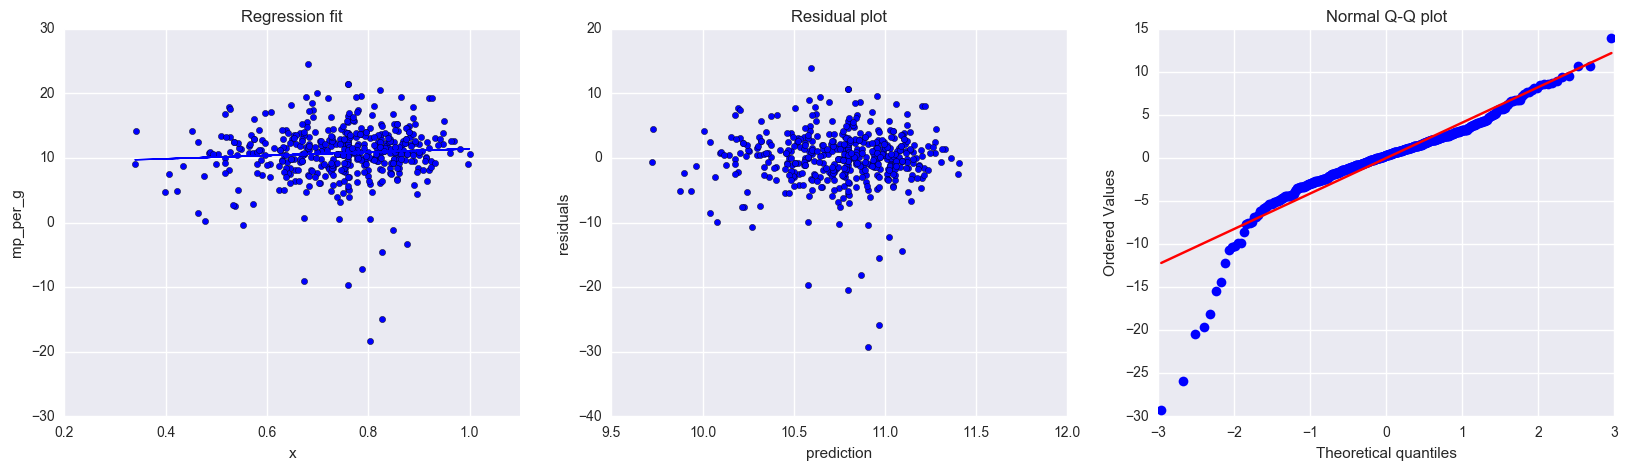

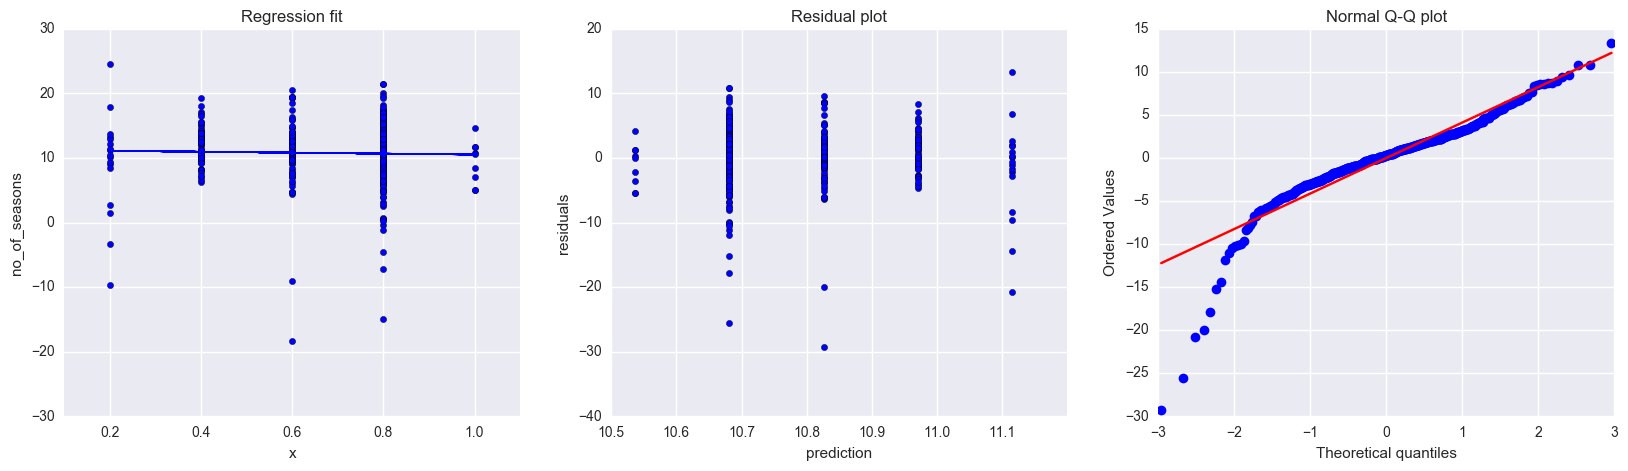

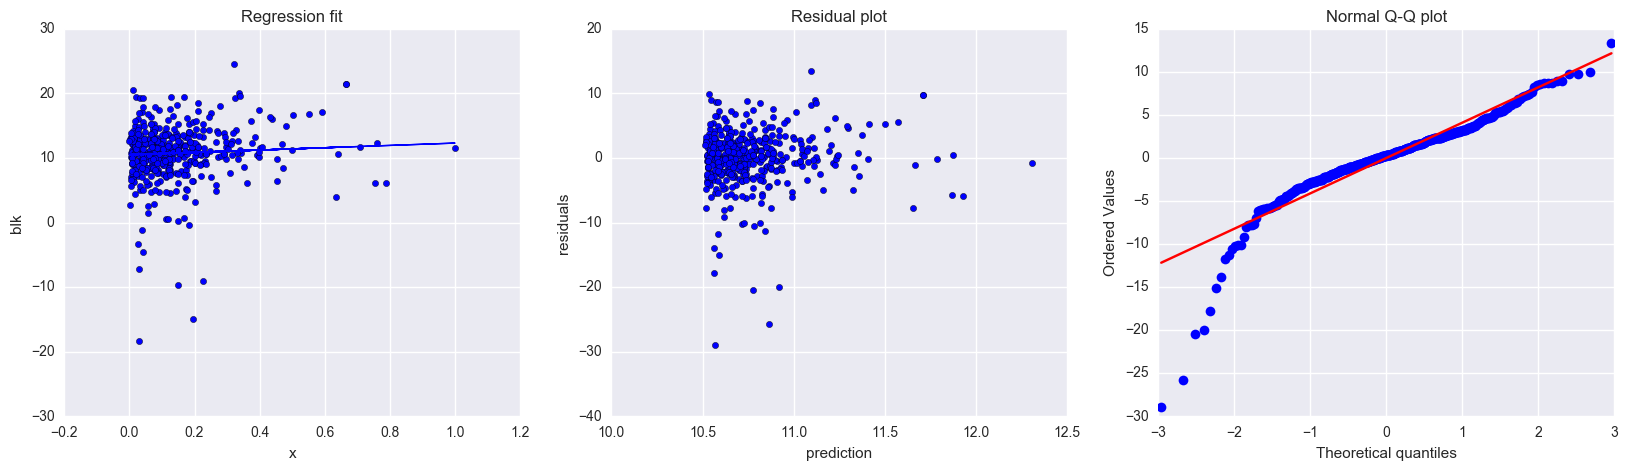

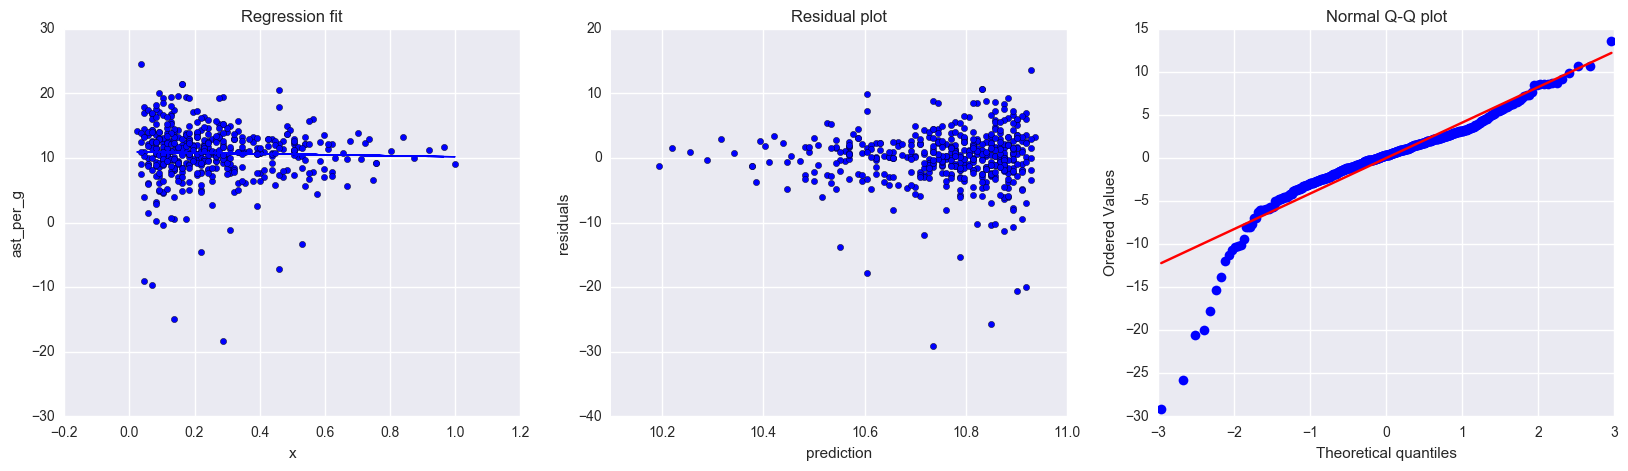

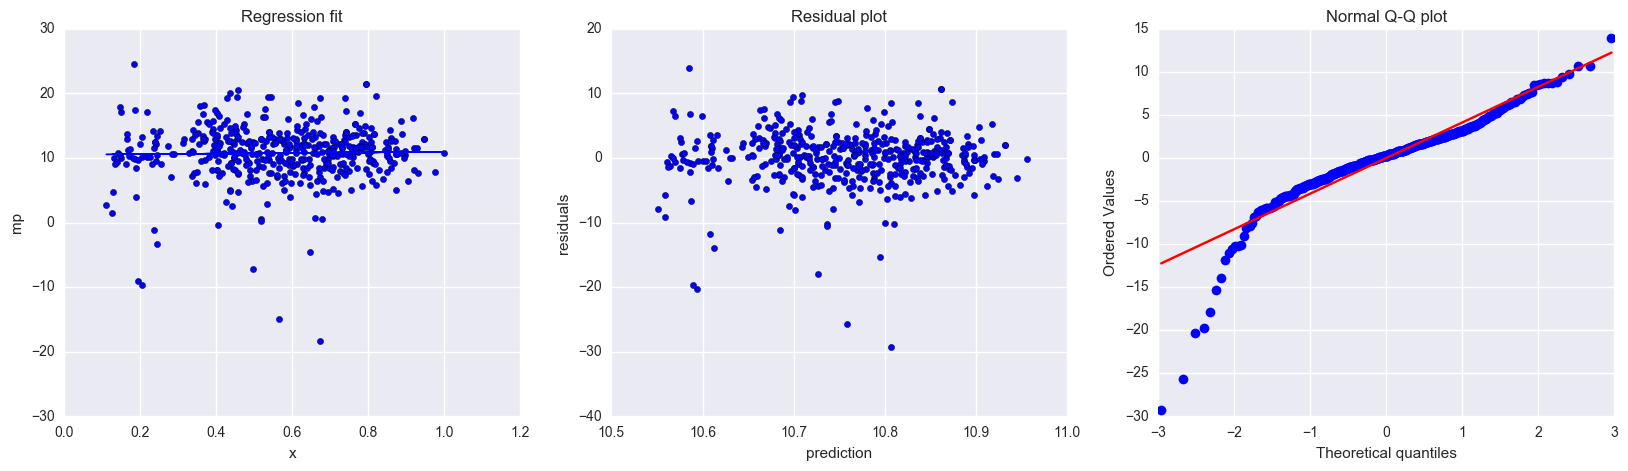

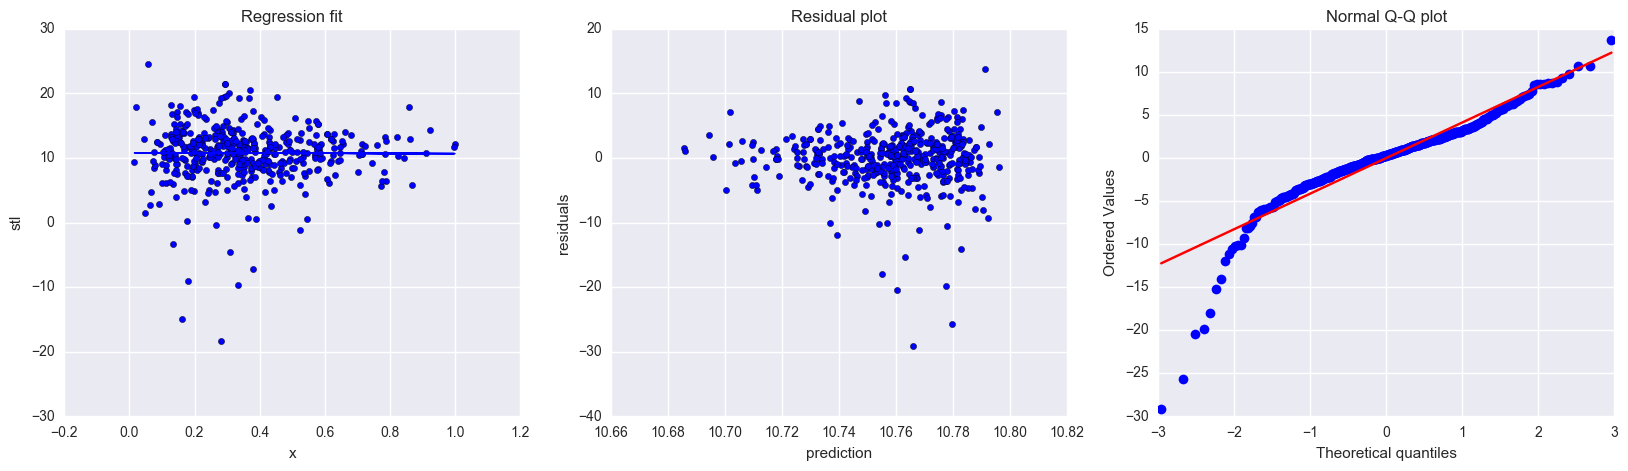

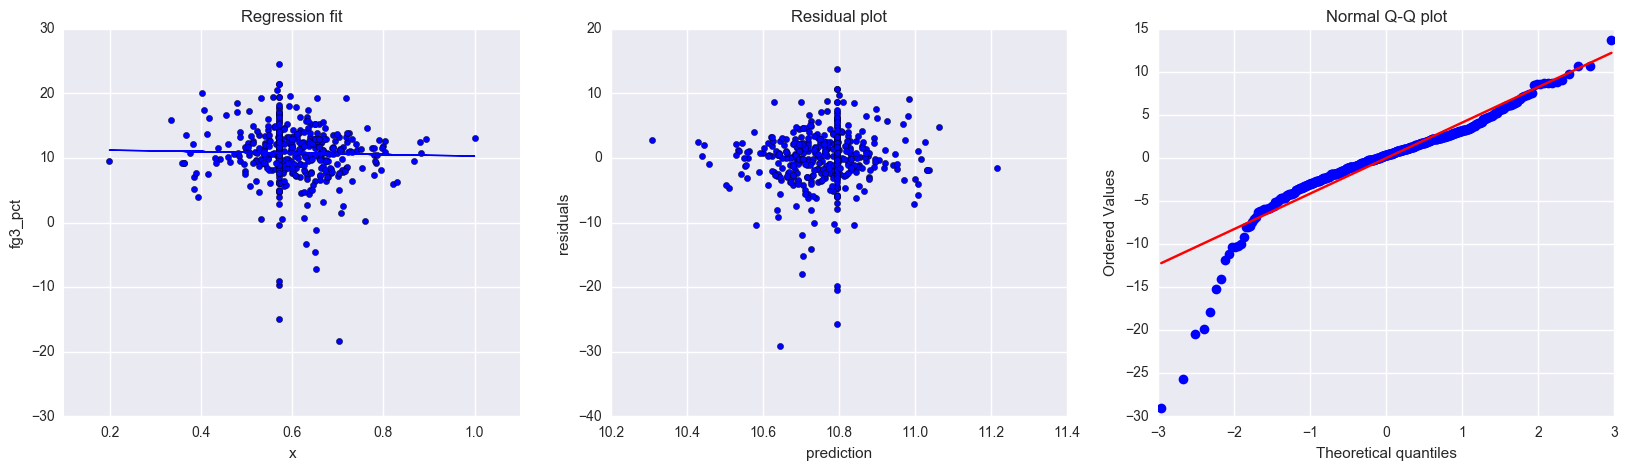

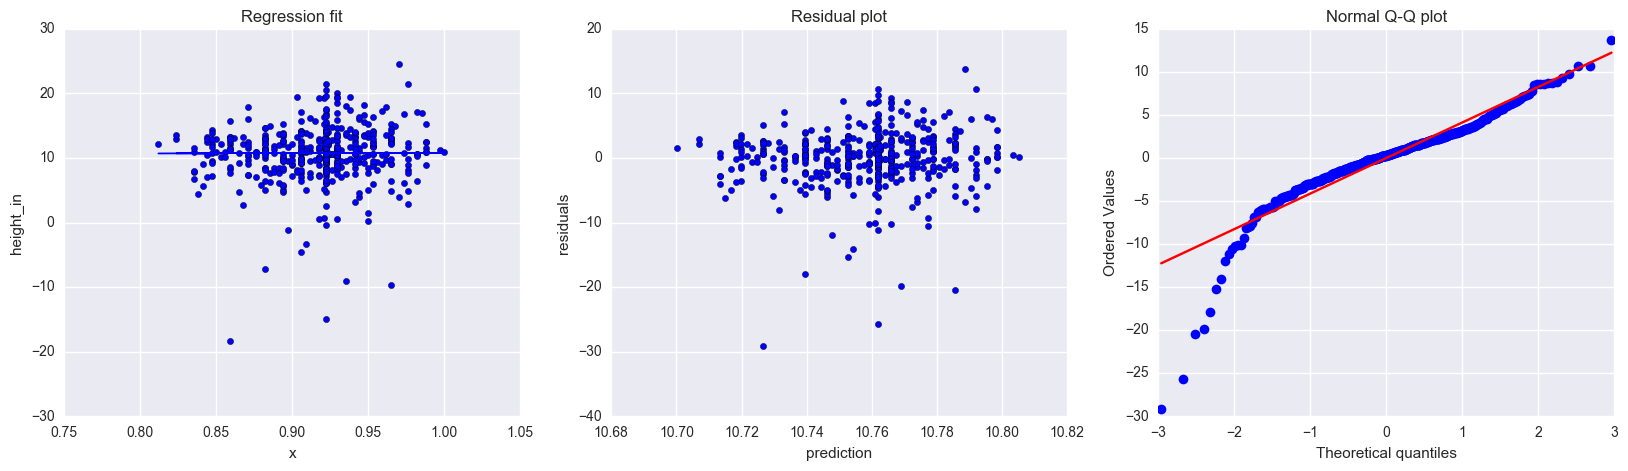

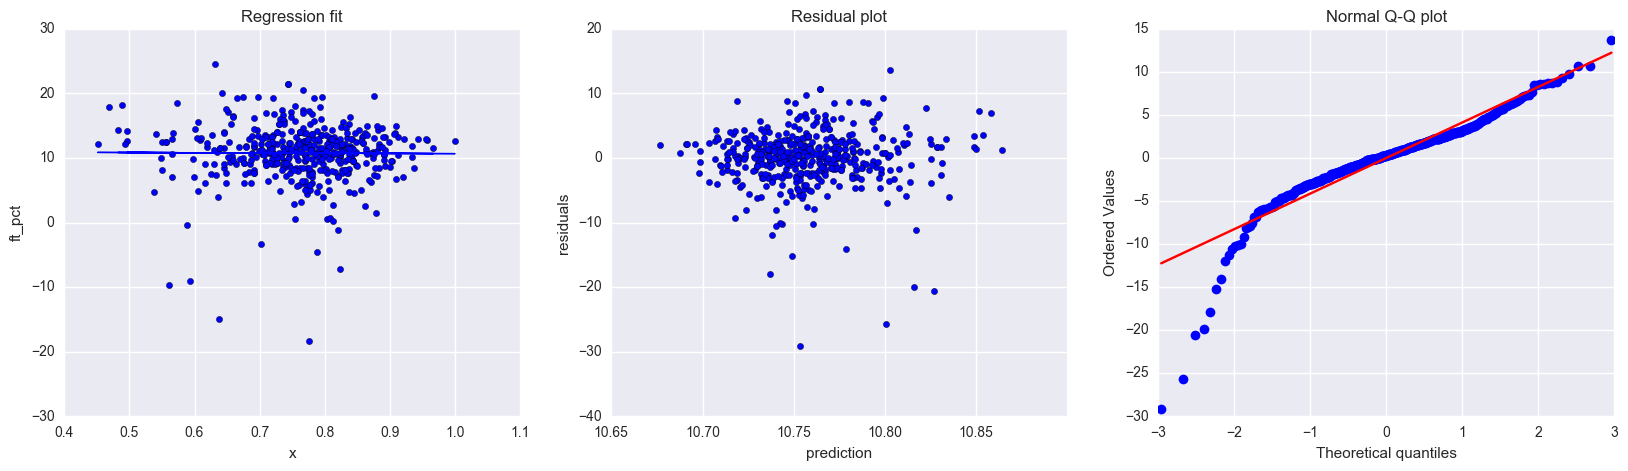

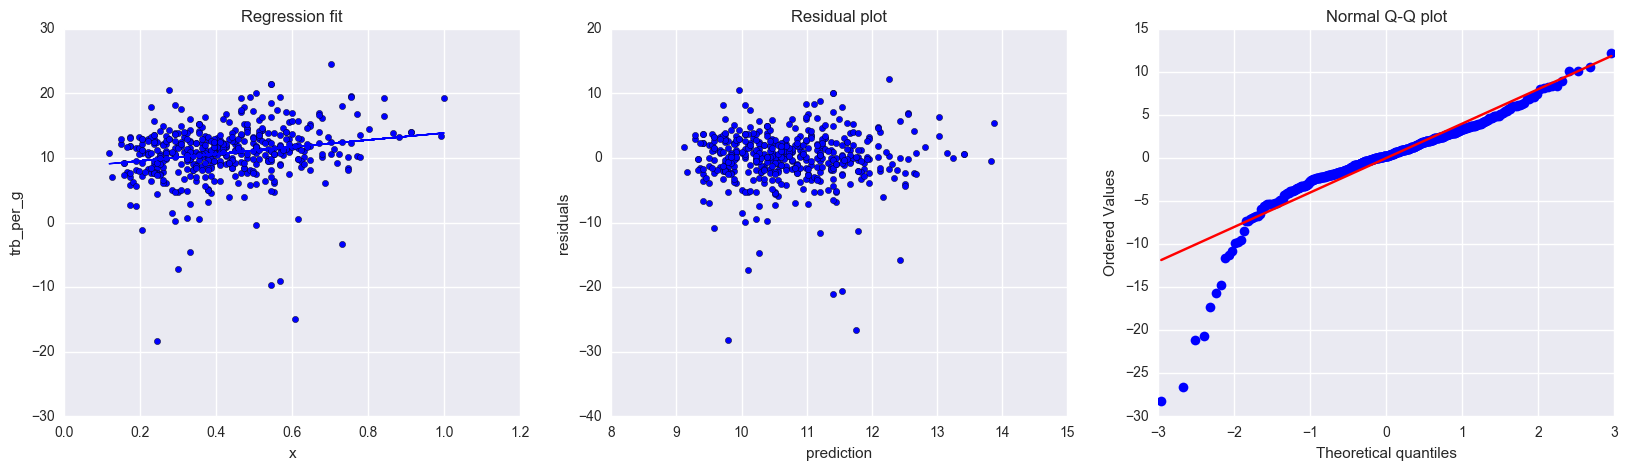

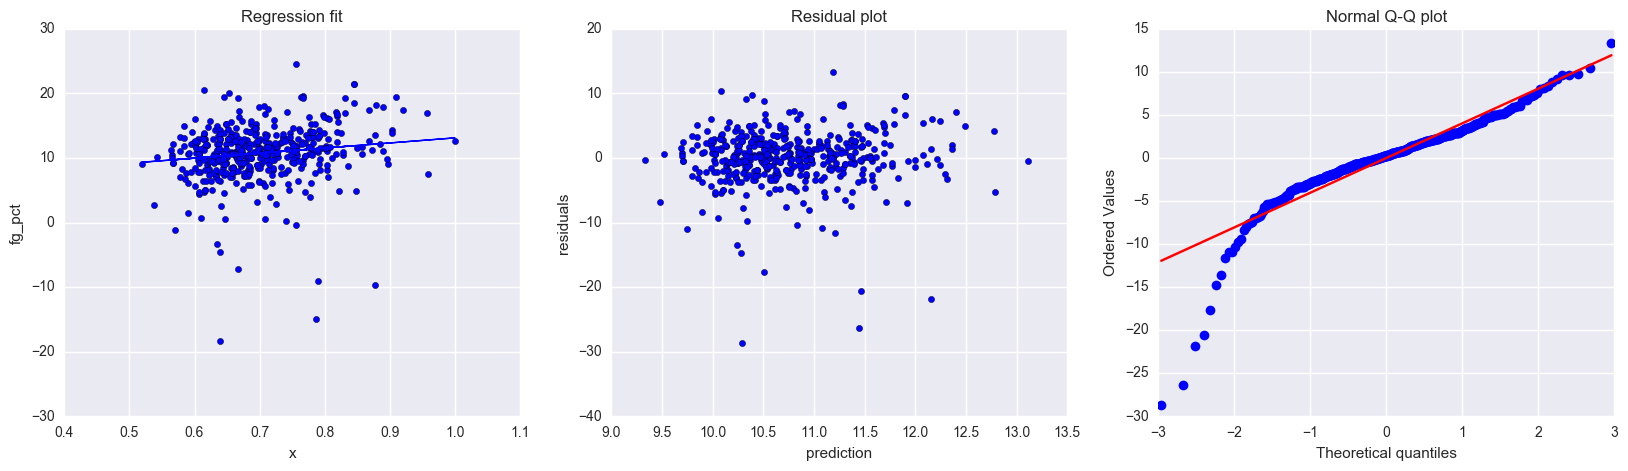

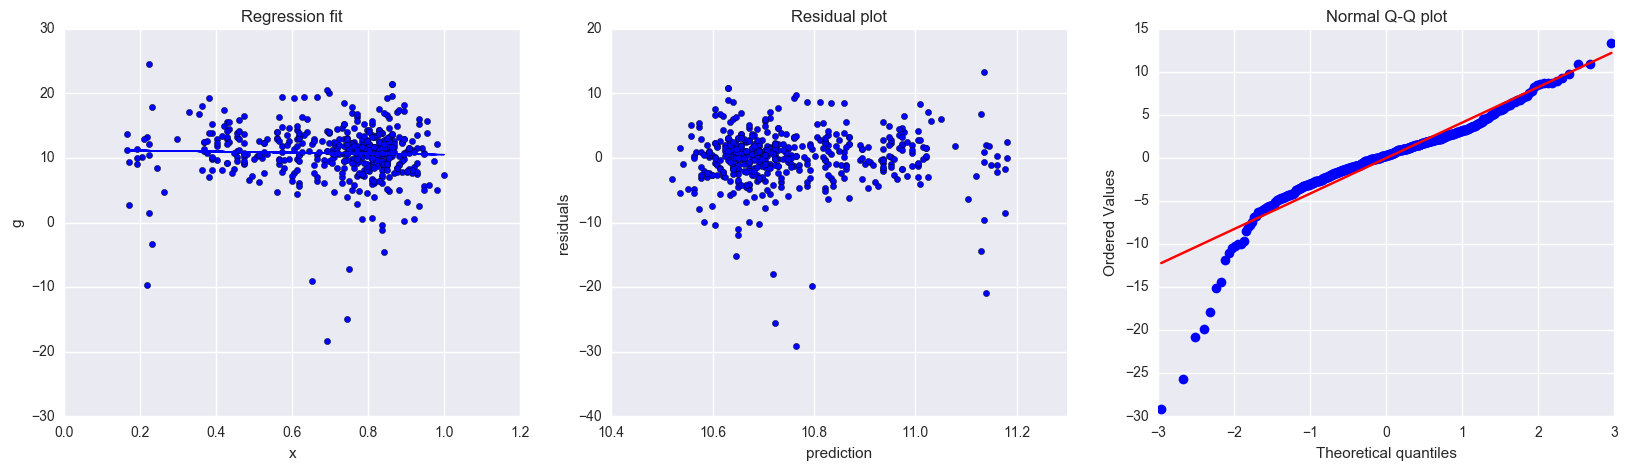

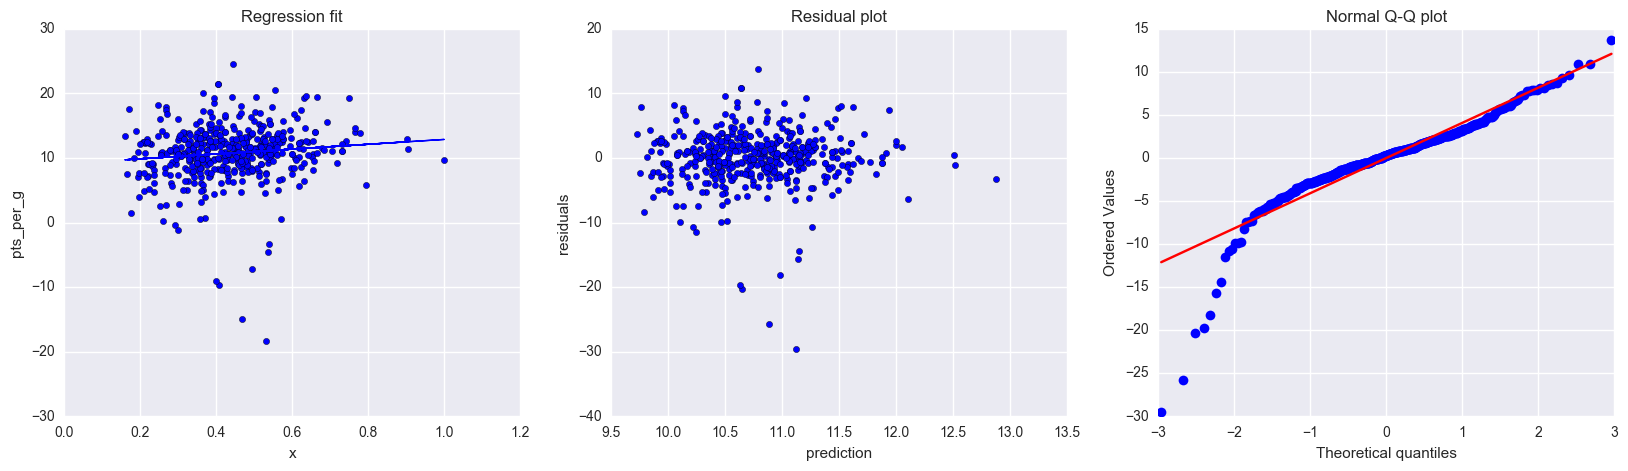

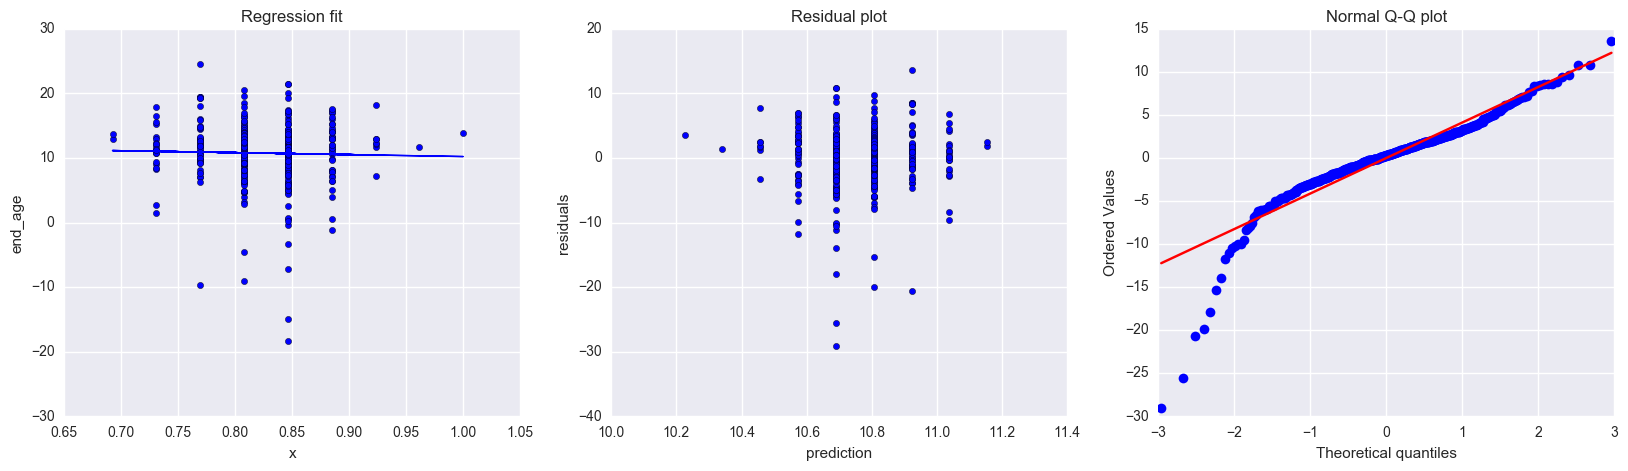

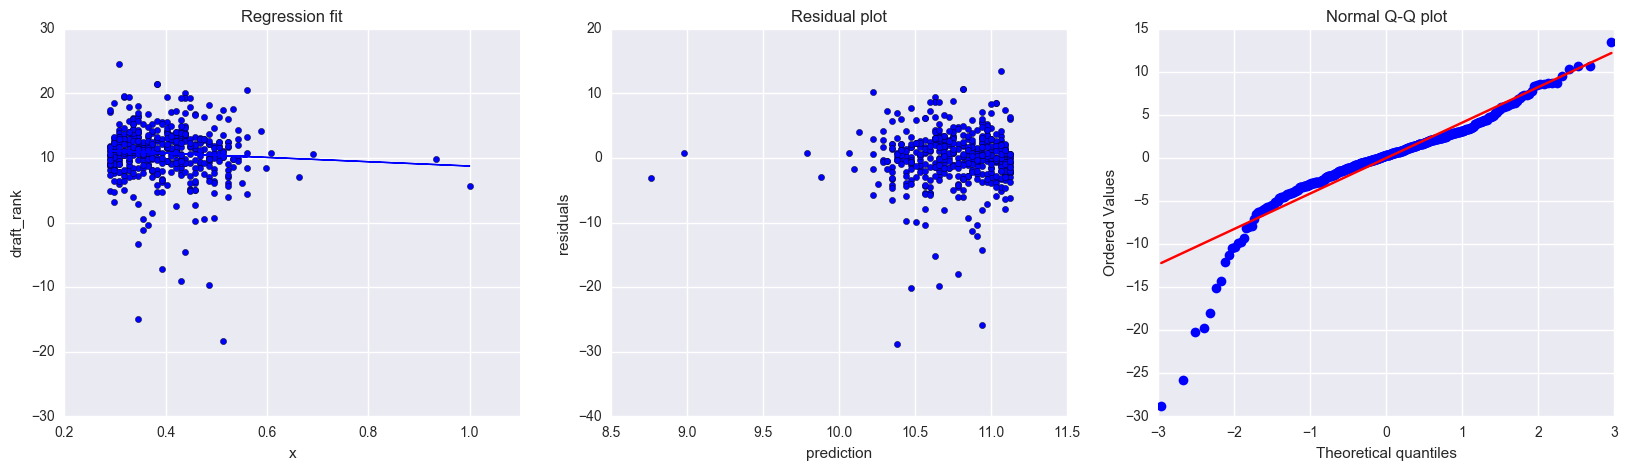

In [156]:
for feature in f:
    diagnostic_plot(X_sc[feature], df_bad['per'], feature)

In [48]:
df.loc[df.position.str.contains('Center'), 'center'] = 1
df.loc[~df.position.str.contains('Center'), 'center'] = 0
df.loc[df.position.str.contains('Guard'), 'guard'] = 1
df.loc[~df.position.str.contains('Guard'), 'guard'] = 0
df.loc[df.position.str.contains('Forward'), 'forward'] = 1
df.loc[~df.position.str.contains('Forward'), 'forward'] = 0

In [51]:
new_cols = x_columns + ['center', 'forward', 'guard']

In [52]:
new_cols = list(set(new_cols) - set(['start_age', 'month', 'end_age']))

/Users/josephinetirtanata/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/josephinetirtanata/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


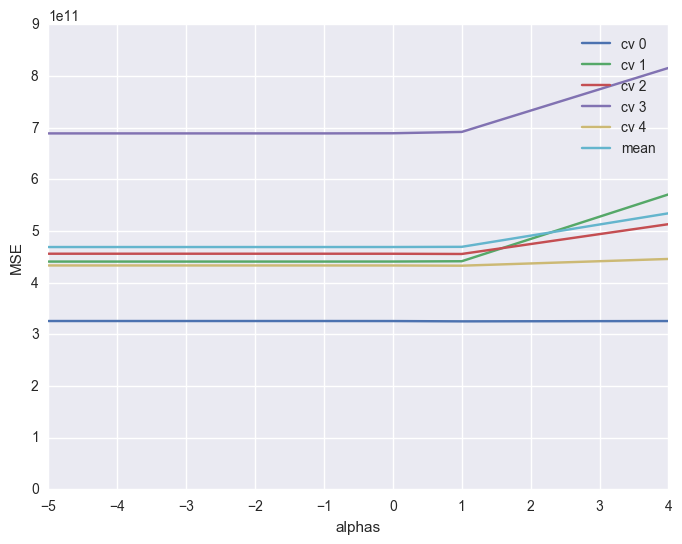

In [69]:
X_sc, y_data, X_data = preprocess(df, cols=new_cols)
pick_alpha(5, X_sc, y_data)

In [70]:
features, est = find_features(-1, X_sc, y_data, new_cols)

0.638209799745


/Users/josephinetirtanata/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [71]:
features

[('draft_year', 55942188.307670988),
 ('fga', 3135098.940294174),
 ('wingspan_in', 2654740.2859454704),
 ('fg_pct', 2359948.1660677246),
 ('fg3', 2156753.4945225003),
 ('pts_per_g', 1614819.7873398066),
 ('fta', 1551449.6780469823),
 ('ast_per_g', 1257947.7605313759),
 ('ft_pct', 773736.71564715996),
 ('g', 642569.47116675333),
 ('weight_lb', 576542.56279499806),
 ('blk', 493859.77421237057),
 ('trb_per_g', 431027.34818684257),
 ('fg3_pct', 147876.49320058781),
 ('mp', 141926.16147850745),
 ('forward', 64995.53976703954),
 ('ast', 23949.089391920214),
 ('center', -17857.139681808785),
 ('guard', -59871.655389696272),
 ('reach_in', -80943.102221377208),
 ('stl', -288946.76774329075),
 ('ft', -669374.12958053395),
 ('no_of_seasons', -819272.47395926213),
 ('height_in', -821858.20763689943),
 ('mp_per_g', -939265.06611719762),
 ('fg', -1037417.4716132239),
 ('fg3a', -1307341.4331132057),
 ('pts', -3917801.6317633078),
 ('draft_rank', -5392601.3800207768)]

In [72]:
f = [x[0] for x in features]
X_sc, y_data, X_data = preprocess(df, f)
rcv = RidgeCV(cv=10)
xtrain, xtest, ytrain, ytest = train_test_split(X_sc, y_data, test_size=0.3)

rcv.fit(X_sc, y_data)
rcv.score(xtest, ytest)

0.63519104160822537

In [73]:
rcv.intercept_

856085.04848878307

In [74]:
print_coef(f, rcv.coef_)

fg_pct			905931.2767846441
g			864647.8461919003
weight_lb			859072.601960355
draft_year			628394.4176461039
blk			596532.8449999796
ast_per_g			592935.9017268282
trb_per_g			568024.7243946805
pts_per_g			544860.7462556212
fg3a			542026.7592849673
ft_pct			494111.2774437225
fg3			468500.0754256194
fta			306957.5237118364
wingspan_in			194459.32696366563
ast			182698.48959497488
ft			109556.55785523128
forward			30912.508774364996
center			-2847.506400761614
guard			-40892.727883786705
reach_in			-41033.32959019017
stl			-161956.23520381132
fg3_pct			-268228.34466886026
mp_per_g			-294725.2068022852
mp			-305856.3002392116
height_in			-335658.5771455757
fga			-370138.124971075
pts			-374907.58869006456
fg			-614162.2325021634
no_of_seasons			-1383001.9013357838
draft_rank			-5071047.348826073


In [124]:
df.sort_values('adjusted_salary', ascending=False)[['name','adjusted_salary']].head(10)

,name,adjusted_salary
733,Karl-Anthony Towns,5760636.0
509,John Wall,5658708.0
467,Blake Griffin,5581497.6
690,Andrew Wiggins,5565746.4
556,Kyrie Irving,5504379.6
650,Anthony Bennett,5484008.4
383,Greg Oden,5407920.0
600,Anthony Davis,5401494.0
425,Derrick Rose,5353308.0
304,Andrew Bogut,5338839.6


/Users/josephinetirtanata/anaconda/lib/python3.5/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/josephinetirtanata/anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


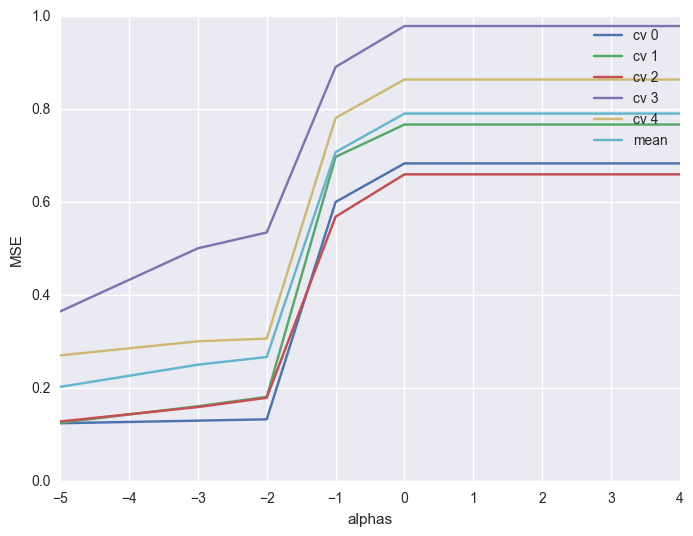

In [109]:

f = [x[0] for x in features]
f = f.extend(['center', 'forward', 'guard'])
X_sc, y_data, X_data = preprocess(df,cols=f, y_val='log_salary')
pick_alpha(5, X_sc, y_data)

In [110]:
features, est = find_features(1e-2, X_sc, y_data, X_data.columns)

0.665077444102


In [111]:
features

[('mp', -0.052710430109907884),
 ('no_of_seasons', -0.39075551841060935),
 ('draft_rank', -4.293340623422182)]

In [112]:
f = [x[0] for x in features]
X_sc, y_data, X_data = preprocess(df, f)
rcv = RidgeCV(cv=10)
xtrain, xtest, ytrain, ytest = train_test_split(X_data, y_data, test_size=0.3)

rcv.fit(X_data, y_data)
rcv.score(xtest, ytest)

0.65423092590487042